In [12]:
import torch

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
EPOCHS = 500
BATCH_SIZE = 32
LR = 0.0005

In [13]:
import os
import zipfile
import opendatasets as od

# Replace 'dataset_name' with the name of the dataset you want to download
od.download('https://www.kaggle.com/datasets/vermaavi/food11')

 22%|██▏       | 495M/2.17G [00:15<00:54, 33.1MB/s] 

KeyboardInterrupt



In [14]:
import os
from torch.utils.data import Dataset
from PIL import Image, ImageDraw, ImageFont

# Custom dataset that inherits from 
class Food11Dataset(Dataset):
    def __init__(self, dir, limit=None, transform=None):
        self.dir = dir
        self.transform = transform

        if limit is None:
            self.file_list = [file for file in os.listdir(dir) if file.endswith('.jpg')]
        else:
            self.file_list = [file for file in os.listdir(dir) if file.endswith('.jpg')][:limit]
        # Get the list of files in the directory, up to the limit
        

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = os.path.join(self.dir, self.file_list[idx])
        
        image = Image.open(path)

        noisy = self.add_watermark(image)
        
        if self.transform:
            image = self.transform(image)
            noisy = self.transform(noisy)

        label = int(self.file_list[idx].split('_')[0])

        return image, noisy, label
    
    def add_watermark(self, image):
        noisy = image.copy()

        draw = ImageDraw.Draw(noisy)

        text = '01.11.2023'

        font = ImageFont.truetype('arial.ttf', 50)

        # Specify the color of the watermark (in this case, white)
        text_color = (255, 255, 255)

        # Draw the watermark on the image
        draw.text((10, 10), text, font=font, fill=text_color)

        return noisy

In [19]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # N, 3, 128, 128
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # N, 16, 64, 64
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # N, 32, 32, 32
            nn.ReLU(),
        )

        # N, 32, 32, 32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 16, 64, 64
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 3, 128, 128
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [20]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

training_data = Food11Dataset('../food11/training', transform=transform, limit=800)

validate_data = Food11Dataset('../food11/validation', transform=transform)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

validate_dataloader = DataLoader(validate_data, batch_size=BATCH_SIZE, shuffle=True)

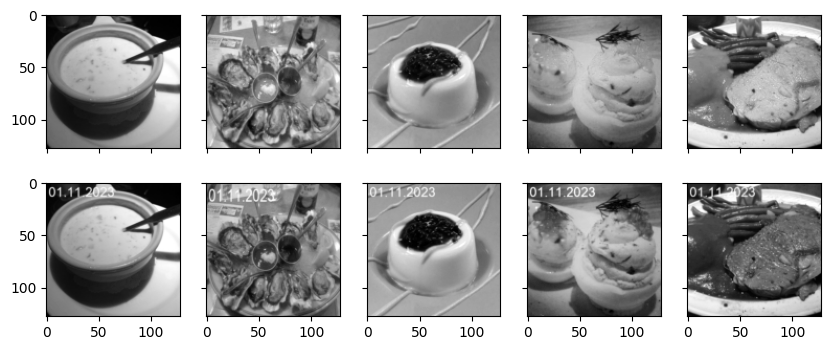

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10,4))

for batch in train_dataloader:
    for i in range(5):
        axes[0][i].imshow(batch[0][i][0], cmap='gray')
        axes[1][i].imshow(batch[1][i][1], cmap='gray')
    break

In [ ]:
from tqdm import tqdm

model = Autoencoder()
model.to(DEVICE)

# model.load_state_dict(torch.load('latest.pth'))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.0005)

for epoch in range(EPOCHS):

    for (original, noisy, labels) in tqdm(train_dataloader):
        noisy = noisy.to(DEVICE)
        original = original.to(DEVICE)

        output = model(noisy)
        loss = criterion(output, original)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss = loss.item()

    # Save loss to a file called loss.txt
    with open('loss.txt', 'a') as f:
        f.write(str(loss) + '\n')

    # Save the model as latest.pth
    torch.save(model.state_dict(), 'latest.pth')

    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

100%|██████████| 25/25 [01:20<00:00,  3.22s/it]


Epoch 1, Loss: 0.0840


100%|██████████| 25/25 [01:17<00:00,  3.10s/it]


Epoch 2, Loss: 0.0679


100%|██████████| 25/25 [03:37<00:00,  8.70s/it]


Epoch 3, Loss: 0.0760


100%|██████████| 25/25 [01:11<00:00,  2.87s/it]


Epoch 4, Loss: 0.0437


100%|██████████| 25/25 [02:36<00:00,  6.25s/it]


Epoch 5, Loss: 0.0312


100%|██████████| 25/25 [01:20<00:00,  3.21s/it]


Epoch 6, Loss: 0.0212


100%|██████████| 25/25 [01:16<00:00,  3.08s/it]


Epoch 7, Loss: 0.0171


100%|██████████| 25/25 [01:14<00:00,  2.96s/it]


Epoch 8, Loss: 0.0141


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


Epoch 9, Loss: 0.0118


100%|██████████| 25/25 [02:25<00:00,  5.84s/it]


Epoch 10, Loss: 0.0106


100%|██████████| 25/25 [01:20<00:00,  3.24s/it]


Epoch 11, Loss: 0.0108


100%|██████████| 25/25 [01:18<00:00,  3.14s/it]


Epoch 12, Loss: 0.0072


100%|██████████| 25/25 [02:22<00:00,  5.69s/it]


Epoch 13, Loss: 0.0076


100%|██████████| 25/25 [01:22<00:00,  3.32s/it]


Epoch 14, Loss: 0.0071


100%|██████████| 25/25 [00:56<00:00,  2.25s/it]


Epoch 15, Loss: 0.0072


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


Epoch 16, Loss: 0.0067


100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


Epoch 17, Loss: 0.0070


100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


Epoch 18, Loss: 0.0066


100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


Epoch 19, Loss: 0.0068


100%|██████████| 25/25 [00:50<00:00,  2.04s/it]


Epoch 20, Loss: 0.0064


100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


Epoch 21, Loss: 0.0075


100%|██████████| 25/25 [00:48<00:00,  1.92s/it]


Epoch 22, Loss: 0.0074


100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


Epoch 23, Loss: 0.0066


100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


Epoch 24, Loss: 0.0066


100%|██████████| 25/25 [00:50<00:00,  2.04s/it]


Epoch 25, Loss: 0.0058


100%|██████████| 25/25 [00:46<00:00,  1.86s/it]


Epoch 26, Loss: 0.0059


100%|██████████| 25/25 [00:48<00:00,  1.95s/it]


Epoch 27, Loss: 0.0057


100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


Epoch 28, Loss: 0.0063


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


Epoch 29, Loss: 0.0057


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Epoch 30, Loss: 0.0060


100%|██████████| 25/25 [00:52<00:00,  2.12s/it]


Epoch 31, Loss: 0.0065


100%|██████████| 25/25 [00:48<00:00,  1.96s/it]


Epoch 32, Loss: 0.0055


100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


Epoch 33, Loss: 0.0054


100%|██████████| 25/25 [00:47<00:00,  1.90s/it]


Epoch 34, Loss: 0.0053


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


Epoch 35, Loss: 0.0066


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


Epoch 36, Loss: 0.0057


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Epoch 37, Loss: 0.0052


100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


Epoch 38, Loss: 0.0052


100%|██████████| 25/25 [00:57<00:00,  2.30s/it]


Epoch 39, Loss: 0.0056


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


Epoch 40, Loss: 0.0058


100%|██████████| 25/25 [00:54<00:00,  2.18s/it]


Epoch 41, Loss: 0.0060


100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


Epoch 42, Loss: 0.0066


100%|██████████| 25/25 [00:54<00:00,  2.20s/it]


Epoch 43, Loss: 0.0060


100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


Epoch 44, Loss: 0.0054


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


Epoch 45, Loss: 0.0055


100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


Epoch 46, Loss: 0.0054


100%|██████████| 25/25 [00:53<00:00,  2.15s/it]


Epoch 47, Loss: 0.0066


100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


Epoch 48, Loss: 0.0053


100%|██████████| 25/25 [00:52<00:00,  2.12s/it]


Epoch 49, Loss: 0.0056


100%|██████████| 25/25 [00:48<00:00,  1.95s/it]


Epoch 50, Loss: 0.0058


100%|██████████| 25/25 [00:49<00:00,  1.97s/it]


Epoch 51, Loss: 0.0052


100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Epoch 52, Loss: 0.0053


100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


Epoch 53, Loss: 0.0056


100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


Epoch 54, Loss: 0.0063


100%|██████████| 25/25 [00:54<00:00,  2.18s/it]


Epoch 55, Loss: 0.0051


100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


Epoch 56, Loss: 0.0056


100%|██████████| 25/25 [00:52<00:00,  2.12s/it]


Epoch 57, Loss: 0.0051


100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


Epoch 58, Loss: 0.0059


100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


Epoch 59, Loss: 0.0057


100%|██████████| 25/25 [00:50<00:00,  2.04s/it]


Epoch 60, Loss: 0.0060


100%|██████████| 25/25 [00:54<00:00,  2.18s/it]


Epoch 61, Loss: 0.0059


100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


Epoch 62, Loss: 0.0056


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


Epoch 63, Loss: 0.0052


100%|██████████| 25/25 [00:49<00:00,  2.00s/it]


Epoch 64, Loss: 0.0056


100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


Epoch 65, Loss: 0.0061


100%|██████████| 25/25 [00:48<00:00,  1.95s/it]


Epoch 66, Loss: 0.0046


100%|██████████| 25/25 [02:02<00:00,  4.92s/it]


Epoch 67, Loss: 0.0067


100%|██████████| 25/25 [00:48<00:00,  1.96s/it]


Epoch 68, Loss: 0.0061


100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


Epoch 69, Loss: 0.0066


100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


Epoch 70, Loss: 0.0055


100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


Epoch 71, Loss: 0.0051


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


Epoch 72, Loss: 0.0054


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


Epoch 73, Loss: 0.0051


100%|██████████| 25/25 [00:47<00:00,  1.90s/it]


Epoch 74, Loss: 0.0050


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


Epoch 75, Loss: 0.0052


100%|██████████| 25/25 [00:47<00:00,  1.90s/it]


Epoch 76, Loss: 0.0055


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


Epoch 77, Loss: 0.0053


100%|██████████| 25/25 [00:49<00:00,  1.96s/it]


Epoch 78, Loss: 0.0053


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


Epoch 79, Loss: 0.0057


100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


Epoch 80, Loss: 0.0058


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Epoch 81, Loss: 0.0055


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


Epoch 82, Loss: 0.0055


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


Epoch 83, Loss: 0.0043


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


Epoch 84, Loss: 0.0052


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Epoch 85, Loss: 0.0049


100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


Epoch 86, Loss: 0.0051


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


Epoch 87, Loss: 0.0048


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Epoch 88, Loss: 0.0055


100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


Epoch 89, Loss: 0.0052


100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


Epoch 90, Loss: 0.0054


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


Epoch 91, Loss: 0.0054


100%|██████████| 25/25 [00:48<00:00,  1.94s/it]


Epoch 92, Loss: 0.0050


100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


Epoch 93, Loss: 0.0056


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Epoch 94, Loss: 0.0056


100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


Epoch 95, Loss: 0.0047


100%|██████████| 25/25 [00:49<00:00,  1.97s/it]


Epoch 96, Loss: 0.0050


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


Epoch 97, Loss: 0.0049


100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


Epoch 98, Loss: 0.0050


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Epoch 99, Loss: 0.0050


100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Epoch 100, Loss: 0.0048


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Epoch 101, Loss: 0.0057


100%|██████████| 25/25 [00:48<00:00,  1.94s/it]


Epoch 102, Loss: 0.0065


100%|██████████| 25/25 [00:51<00:00,  2.04s/it]


Epoch 103, Loss: 0.0058


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


Epoch 104, Loss: 0.0054


100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


Epoch 105, Loss: 0.0051


 36%|███▌      | 9/25 [00:21<00:34,  2.16s/it]